# Result Notebook

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import multimodal_mazes
import seaborn as sns

## Parameters, Hyperparameters and Helper Functions

In [2]:
actions = {
    0: {'name':'Up', 'delta':(-1, 0)},
    1: {'name':'Down', 'delta':(1, 0)},
    2: {'name':'Right', 'delta':(0, 1)},
    3: {'name':'Left', 'delta':(0, -1)},
    4: {'name':'Up-Right', 'delta':(-1, 1)},
    5: {'name':'Up-Left', 'delta':(-1, -1)},
    6: {'name':'Down-Right', 'delta':(1, 1)},
    7: {'name':'Down-Left', 'delta':(1, -1)},
}

width=21
height=20
pk = 40
pk_hw = pk // 2
agent_location = np.array([pk_hw + (height // 2), pk_hw + (width // 2)])
n_prey = 1
n_steps = 100
n_trials = 100
visible_steps = n_steps
n_features = 12
cost_per_step = -1
cost_per_collision = -10
alpha = 0.2
epsilon = 0.2
gamma = 0.9

def static_hyperparamters():
    scenario =  "Static"
    multisensory = "Unisensory"
    pc = 0.0
    pm = 0
    pe = 1
    noise = 0
    case = None
    motion = None
    return scenario, multisensory, pc, pm, pe, noise, case, motion

def constant_hyperparameters():
    scenario =  "Constant"
    motion = "Linear"
    multisensory = "Unisensory" 
    pc = 0.0
    pm = 1
    pe = 1
    noise = 0
    case = None
    return scenario, motion, multisensory, pc, pm, pe, noise, case, motion

In [3]:
def plot_feature_importance_heatmap(agent):
    feature_importance = abs(agent.theta)
    feature_importance = feature_importance / np.max(feature_importance, axis=0)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(feature_importance, annot=True, cmap="YlGnBu", xticklabels=[f'Action {i}' for i in range(agent.n_actions)], yticklabels=[f'Feature {i}' for i in range(agent.n_features)])
    plt.title('Feature Importance Heatmap')
    plt.xlabel('Actions')
    plt.ylabel('Features')
    plt.show()

## Static Training Test

In [ ]:
scenario, multisensory, pc, pm, pe, noise, case, motion = static_hyperparamters()
agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=agent_location, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
training_evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
training_evaluator.train_RL(training_trials=2000)

In [ ]:
training_evaluator.training_plots(training_lengths=True, first_5_last_5=True)

In [ ]:
plot_feature_importance_heatmap(agnt)

## Constant Movement Training Test

In [ ]:
scenario, motion, multisensory, pc, pm, pe, noise, case, motion = constant_hyperparameters()
agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=agent_location, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
training_evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
training_evaluator.train_RL(training_trials = 5000)

In [ ]:
training_evaluator.training_plots(percentage_captured=True)

In [ ]:
training_evaluator.training_plots(first_5_last_5=True)

In [ ]:
plot_feature_importance_heatmap(agnt)

In [ ]:
training_evaluator.training_plots(animate=[True, 4894])

## Success vs Speed

### Results Storage and Hyperparameters

In [4]:
scenario, motion, multisensory, pc, pm, pe, noise, case, motion = constant_hyperparameters()
n_agents = 4
cases = ["1", "2", "3"]
pms = np.arange(0, 1.1, 0.1)
case_colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
capture_results = np.zeros((n_agents, len(cases), len(pms)))
approach_results = np.zeros((n_agents, len(cases), len(pms)))           
trials = {n: {case: {pm: {} for pm in range(len(pms))} for case in range(len(cases))} for n in range(n_agents)}

### Agent Training and Testing

In [ ]:
for n in range(n_agents):
    agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=agent_location, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
    evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
    evaluator.train_RL(training_trials = 6000)

    if n == n_agents - 1:
        # evaluator.training_plots(percentage_captured=True)
        evaluator.training_plots(first_5_last_5=True)

    for case in range(len(cases)):
        for a, pm in tqdm(enumerate(pms)):
            test_trial_data, captured, approached = evaluator.evaluate(n_trials=n_trials, case=cases[case], pm=pm)
            trials[n][case][a] = test_trial_data
            capture_results[n, case, a] = captured
            approach_results[n, case, a] = approached
            # evaluator.agnt.produce_plots(training_lengths=False, first_5_last_5=False, percentage_captured=False, animate=[True, 0], trials=test_trial_data, trial_lengths=[])

### Results Processing and Plotting

#### Capture

In [ ]:
capture_processed = np.zeros((2, len(cases), len(pms)))
capture_results_mod = capture_results.copy()
# capture_results_mod = np.delete(capture_results.copy(), , )

for case in range(len(cases)):
    for pm in range(len(pms)):
        capture_processed[0, case, pm] = np.mean(capture_results_mod[:, case, pm])
        capture_processed[1, case, pm] = np.std(capture_results_mod[:, case, pm])


print('Capture Results:')
print(capture_results)
print('Processed Capture Results:')
print(capture_processed)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} RL Capture Success vs Speed")

for case in range(len(cases)):
    axs[case].set_title(f"Case {case + 1}")
    for n in range(n_agents):
        axs[case].plot(pms, capture_results[n, case, :], color = case_colors[case], alpha = 0.2)
    
    axs[case].plot(pms, capture_processed[0, case, :], color=case_colors[case])
    axs[case].errorbar(pms, capture_processed[0, case, :], yerr=capture_processed[1, case, :], color=case_colors[case])
    axs[3].plot(pms, capture_processed[0, case, :], color=case_colors[case])
    axs[3].errorbar(pms, capture_processed[0, case, :], yerr=capture_processed[1, case, :], color=case_colors[case])
    
axs[0].set(xlabel='Speed', ylabel='Capture Success')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

#### Approach

In [ ]:
approach_processed = np.zeros((2, len(cases), len(pms)))

for case in range(len(cases)):
    for pm in range(len(pms)):
        approach_processed[0, case, pm] = np.mean(approach_results[:, case, pm])
        approach_processed[1, case, pm] = np.std(approach_results[:, case, pm])

print('Approach Results:')
print(approach_results)
print('Processed Approach Results:')
print(approach_processed)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} RL Approach Success vs Speed")

for case in range(len(cases)):
    axs[case].set_title(f"Case {case + 1}")
    for n in range(n_agents-1):
        axs[case].plot(pms, approach_results[n, case, :], color = case_colors[case], alpha = 0.2)
    
    axs[case].plot(pms, approach_processed[0, case, :], color=case_colors[case])
    axs[case].errorbar(pms, approach_processed[0, case, :], yerr=approach_processed[1, case, :], color=case_colors[case])
    axs[3].plot(pms, approach_processed[0, case, :], color=case_colors[case])
    axs[3].errorbar(pms, approach_processed[0, case, :], yerr=approach_processed[1, case, :], color=case_colors[case])
    
axs[0].set(xlabel='Speed', ylabel='Approach Success')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

### Trajectory Plotting

In [11]:
colors = {0: [plt.get_cmap('Blues')(i) for i in np.arange(0, 1.1, 0.1)], 
          1: [plt.get_cmap('Oranges')(i) for i in np.arange(0, 1.1, 0.1)], 
          2: [plt.get_cmap('Reds')(i) for i in np.arange(0, 1.1, 0.1)]}

coords = {case: {'y': {pm: [] for pm in range(len(pms))}, 'x': {pm: [] for pm in range(len(pms))}} for case in range(len(cases))}
mean_coords = {case: {'mean_x': {pm: [] for pm in range(len(pms))}, 'unique_y': {pm: [] for pm in range(len(pms))}} for case in range(len(cases))}
    
for case in range(len(cases)):
    for agent in range(n_agents):          
        for a in range(len(pms)):
            x_coords, y_coords = [], []
            
            for trial in trials[agent][case][a]:
                path = trials[agent][case][a][trial]['path']
                for location in path:
                    y = height + pk - location[0]
                    x = width + pk - location[1] if path[0][1] < path[-1][1] else location[1]
                    y_coords.append(y)
                    x_coords.append(x)
                    
            coords[case]['y'][a] = y_coords
            coords[case]['x'][a] = x_coords

            x_values = np.array(x_coords)
            y_values = np.array(y_coords)
            unique_ys = np.unique(y_values)

            mean_xs = np.array([x_values[y_values == y].mean() for y in unique_ys])
            mean_coords[case]['mean_x'][a] = mean_xs
            mean_coords[case]['unique_y'][a] = unique_ys


In [ ]:
for a in range(len(pms)):
    # plt.plot(coords[0]['x'][a], coords[0]['y'][a], color=colors[0][a], alpha=0.01)
    plt.plot(mean_coords[0]['mean_x'][a], mean_coords[0]['unique_y'][a], label=np.round(pms[a], 1), color=colors[0][a])
    
plt.title('Case 1')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(pms)):
    # plt.plot(coords[1]['x'][a], coords[1]['y'][a], color=colors[1][a], alpha=0.01)
    plt.plot(mean_coords[1]['mean_x'][a], mean_coords[1]['unique_y'][a], label=np.round(pms[a], 1), color=colors[1][a])
    
plt.title('Case 2')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(pms)):
    # plt.plot(coords[2]['x'][a], coords[2]['y'][a], color=colors[2][a], alpha=0.01)
    plt.plot(mean_coords[2]['mean_x'][a], mean_coords[2]['unique_y'][a], label=np.round(pms[a], 1), color=colors[2][a])
    
    
plt.title('Case 3')
plt.axis("off")        
plt.legend()

## Curriculum Learning Success vs Speed

### Results Storage and Hyperparameters

In [4]:
scenario, motion, multisensory, pc, pm, pe, noise, case, motion = constant_hyperparameters()
n_agents = 4
cases = ["1", "2", "3"]
pms = np.arange(0, 1.1, 0.1)
case_colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
capture_results = np.zeros((n_agents, len(cases), len(pms)))
approach_results = np.zeros((n_agents, len(cases), len(pms)))           
trials = {n: {case: {pm: {} for pm in range(len(pms))} for case in range(len(cases))} for n in range(n_agents)}

### Agent Training and Testing

In [ ]:
for n in range(n_agents):
    agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=agent_location, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
    evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
    evaluator.train_RL(training_trials = 10000, curriculum=True)

    if n == n_agents - 1:
        # evaluator.training_plots(percentage_captured=True)
        evaluator.training_plots(first_5_last_5=True)

    for case in range(len(cases)):
        for a, pm in tqdm(enumerate(pms)):
            test_trial_data, captured, approached = evaluator.evaluate(n_trials=n_trials, case=cases[case], pm=pm)
            trials[n][case][a] = test_trial_data
            capture_results[n, case, a] = captured
            approach_results[n, case, a] = approached
            # evaluator.agnt.produce_plots(training_lengths=False, first_5_last_5=False, percentage_captured=False, animate=[True, 0], trials=test_trial_data, trial_lengths=[])

### Results Processing and Plotting

#### Capture

In [ ]:
capture_processed = np.zeros((2, len(cases), len(pms)))
capture_results_mod  = capture_results.copy()
# capture_results_mod  = np.delete(capture_results.copy(), , )

for case in range(len(cases)):
    for pm in range(len(pms)):
        capture_processed[0, case, pm] = np.mean(capture_results_mod[:, case, pm])
        capture_processed[1, case, pm] = np.std(capture_results_mod[:, case, pm])

print('Capture Results:')
print(capture_results)
print('Processed Capture Results:')
print(capture_processed)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} RL Capture Success vs Speed")

for case in range(len(cases)):
    axs[case].set_title(f"Case {case + 1}")
    for n in range(n_agents):
        axs[case].plot(pms, capture_results[n, case, :], color = case_colors[case], alpha = 0.2)
    
    axs[case].plot(pms, capture_processed[0, case, :], color=case_colors[case])
    axs[case].errorbar(pms, capture_processed[0, case, :], yerr=capture_processed[1, case, :], color=case_colors[case])
    axs[3].plot(pms, capture_processed[0, case, :], color=case_colors[case])
    axs[3].errorbar(pms, capture_processed[0, case, :], yerr=capture_processed[1, case, :], color=case_colors[case])
    
axs[0].set(xlabel='Speed', ylabel='Capture Success')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

#### Approach

In [ ]:
approach_processed = np.zeros((2, len(cases), len(pms)))

for case in range(len(cases)):
    for pm in range(len(pms)):
        approach_processed[0, case, pm] = np.mean(approach_results[:, case, pm])
        approach_processed[1, case, pm] = np.std(approach_results[:, case, pm])

print('Approach Results:')
print(approach_results)
print('Processed Approach Results:')
print(approach_processed)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} RL Approach Success vs Speed")

for case in range(len(cases)):
    axs[case].set_title(f"Case {case + 1}")
    for n in range(n_agents):
        axs[case].plot(pms, approach_results[n, case, :], color = case_colors[case], alpha = 0.2)
    
    axs[case].plot(pms, approach_processed[0, case, :], color=case_colors[case])
    axs[case].errorbar(pms, approach_processed[0, case, :], yerr=approach_processed[1, case, :], color=case_colors[case])
    axs[3].plot(pms, approach_processed[0, case, :], color=case_colors[case])
    axs[3].errorbar(pms, approach_processed[0, case, :], yerr=approach_processed[1, case, :], color=case_colors[case])
    
axs[0].set(xlabel='Speed', ylabel='Approach Success')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

### Trajectory Plotting

In [12]:
colors = {0: [plt.get_cmap('Blues')(i) for i in np.arange(0, 1.1, 0.1)], 
          1: [plt.get_cmap('Oranges')(i) for i in np.arange(0, 1.1, 0.1)], 
          2: [plt.get_cmap('Reds')(i) for i in np.arange(0, 1.1, 0.1)]}

coords = {case: {'y': {pm: [] for pm in range(len(pms))}, 'x': {pm: [] for pm in range(len(pms))}} for case in range(len(cases))}
mean_coords = {case: {'mean_x': {pm: [] for pm in range(len(pms))}, 'unique_y': {pm: [] for pm in range(len(pms))}} for case in range(len(cases))}
    
for case in range(len(cases)):
    for agent in range(n_agents):          
        for a in range(len(pms)):
            x_coords, y_coords = [], []
            reverse_x = trials[agent][case][a][0]['path'][0][1] < trials[agent][case][a][0]['path'][-1][1] 
            
            for trial in trials[agent][case][a]:
                path = trials[agent][case][a][trial]['path']
                for location in path:
                    y = height + pk - location[0]
                    x = width + pk - location[1] if path[0][1] < path[-1][1] else location[1]
                    y_coords.append(y)
                    x_coords.append(x)
                    
            coords[case]['y'][a] = y_coords
            coords[case]['x'][a] = x_coords

            x_values = np.array(x_coords)
            y_values = np.array(y_coords)
            unique_ys = np.unique(y_values)

            mean_xs = np.array([x_values[y_values == y].mean() for y in unique_ys])
            mean_coords[case]['mean_x'][a] = mean_xs
            mean_coords[case]['unique_y'][a] = unique_ys


In [ ]:
for a in range(len(pms)):
    # plt.plot(coords[0]['x'][a], coords[0]['y'][a], color=colors[0][a], alpha=0.01)
    plt.plot(mean_coords[0]['mean_x'][a], mean_coords[0]['unique_y'][a], label=np.round(pms[a], 1), color=colors[0][a])
    
plt.title('Case 1')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(pms)):
    # plt.plot(coords[1]['x'][a], coords[1]['y'][a], color=colors[1][a], alpha=0.01)
    plt.plot(mean_coords[1]['mean_x'][a], mean_coords[1]['unique_y'][a], label=np.round(pms[a], 1), color=colors[1][a])
    
plt.title('Case 2')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(pms)):
    # plt.plot(coords[2]['x'][a], coords[2]['y'][a], color=colors[2][a], alpha=0.01)
    plt.plot(mean_coords[2]['mean_x'][a], mean_coords[2]['unique_y'][a], label=np.round(pms[a], 1), color=colors[2][a])
    
    
plt.title('Case 3')
plt.axis("off")        
plt.legend()

## Disappearing Success vs Speed

### Results Storage and Hyperparameters

In [4]:
scenario, motion, multisensory, pc, pm, pe, noise, case, motion = constant_hyperparameters()
n_agents = 4
visible_steps = None
times_to_disappear = [1, 5, 10, 20]
cases = ["1", "2", "3"]
pms = np.arange(0, 0.8, 0.25)
case_colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
capture_results = np.zeros((n_agents, len(cases), len(pms), len(times_to_disappear)))
approach_results = np.zeros((n_agents, len(cases), len(pms), len(times_to_disappear)))           
trials = {n: {case: {pm: {time: {} for time in range(len(times_to_disappear))} for pm in range(len(pms))} for case in range(len(cases))} for n in range(n_agents)}

### Agent Training and Testing

100%|██████████| 10000/10000 [00:30<00:00, 327.58it/s]
4it [00:06,  1.71s/it]
4it [00:16,  4.08s/it]
4it [00:09,  2.27s/it]
100%|██████████| 10000/10000 [01:11<00:00, 139.54it/s]
4it [00:27,  6.78s/it]
4it [00:30,  7.75s/it]
4it [00:24,  6.17s/it]
100%|██████████| 10000/10000 [01:49<00:00, 91.25it/s]
4it [00:32,  8.01s/it]
4it [00:39,  9.87s/it]
4it [00:23,  5.88s/it]
100%|██████████| 10000/10000 [04:32<00:00, 36.74it/s]
4it [00:49, 12.26s/it]
4it [01:12, 18.19s/it]
4it [00:45, 11.28s/it]


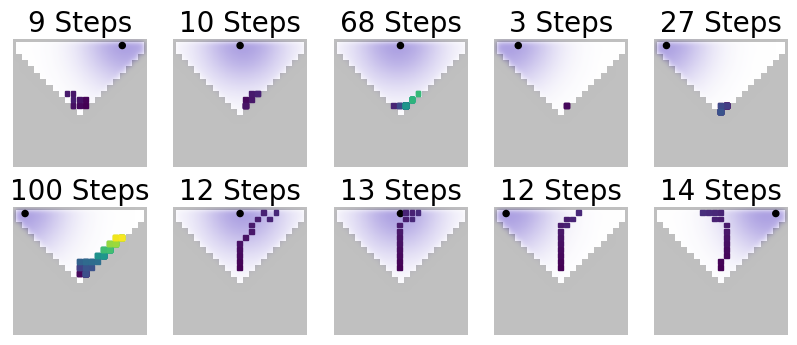

In [5]:
for n in range(n_agents):
    agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=agent_location, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
    evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
    evaluator.train_RL(training_trials = 10000)

    if n == n_agents - 1:
        # evaluator.training_plots(percentage_captured=True)
        evaluator.training_plots(first_5_last_5=True)

    for case in range(len(cases)):
        for a, pm in tqdm(enumerate(pms)):
            for b in range(len(times_to_disappear)):
                visible_steps = times_to_disappear[b]
                test_trial_data, captured, approached = evaluator.evaluate(n_trials=n_trials, case=cases[case], pm=pm, visible_steps=visible_steps)
                trials[n][case][a][b] = test_trial_data
                capture_results[n, case, a, b] = captured
                approach_results[n, case, a, b] = approached
                # evaluator.agnt.produce_plots(training_lengths=False, first_5_last_5=False, percentage_captured=False, animate=[True, 0], trials=test_trial_data, trial_lengths=[])

### Results Processing and Plotting

#### Approach

In [6]:
approach_processed = np.zeros((2, len(cases), len(pms), len(times_to_disappear)))

for case in range(len(cases)):
    for pm in range(len(pms)):
        for time in range(len(times_to_disappear)):
            approach_processed[0, case, pm, time] = np.mean(approach_results[:, case, pm, time])
            approach_processed[1, case, pm, time] = np.std(approach_results[:, case, pm, time])

print('Approach Results:')
print(approach_results)
print('Processed Approach Results:')
print(approach_processed)

Approach Results:
[[[[  0.   0. 100. 100.]
   [  0.   0.  91. 100.]
   [  0.   0.  74.  99.]
   [  0.   0.   9.  48.]]

  [[  0.   0. 100. 100.]
   [  0.   0.  85. 100.]
   [  0.   0.  86. 100.]
   [  0.   0.  82. 100.]]

  [[  0.   0. 100. 100.]
   [  0.   0.  66.  72.]
   [  0.   0.   8.  14.]
   [  0.   0.   0.   0.]]]


 [[[  0.   0. 100. 100.]
   [ 48.  50.  87. 100.]
   [ 53.  18.  43.  95.]
   [ 42.   3.   3.  48.]]

  [[ 55.  54. 100. 100.]
   [ 57.  55.  73.  77.]
   [ 53.  54.  77.  99.]
   [ 55.  56.  85.  99.]]

  [[ 47.  43.  57.  50.]
   [ 16.  15.  68.  74.]
   [  0.   1.  10.   9.]
   [  0.   0.   0.   0.]]]


 [[[  0.   0. 100. 100.]
   [ 49.  50.  91. 100.]
   [ 38.  20.  36.  98.]
   [ 11.   0.   7.  46.]]

  [[  0.   0.  55. 100.]
   [ 85.  87.  92. 100.]
   [ 64.  57.  84. 100.]
   [ 46.  54.  73.  98.]]

  [[ 48.  51. 100. 100.]
   [  0.   0.  37.  61.]
   [  0.   0.   4.   3.]
   [  0.   0.   0.   0.]]]


 [[[  0.   0. 100. 100.]
   [  0.   0.  87. 100.]
   [  0.

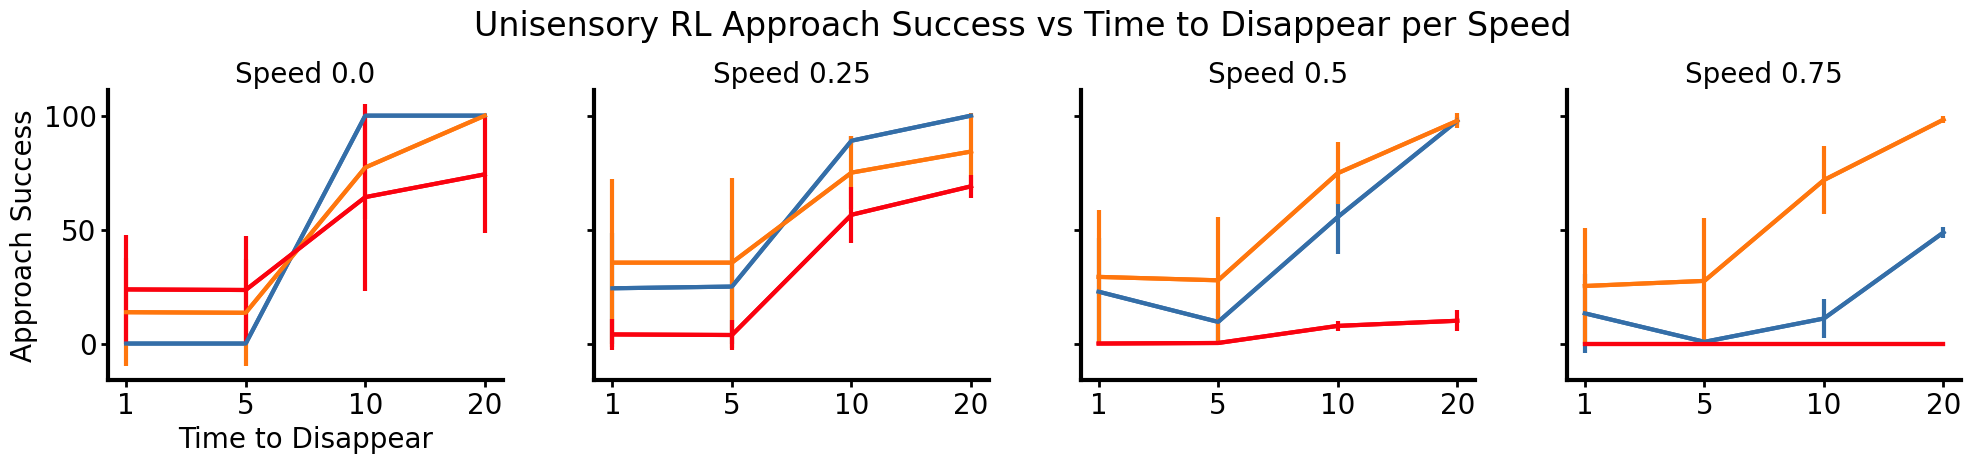

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} RL Approach Success vs Time to Disappear per Speed")

# agents, cases, times, speeds

for pm in range(len(pms)):
    for case in range(len(cases)):
        axs[pm].set_title(f"Speed {pms[pm]}")
        # for n in range(n_agents):
        #     axs[pm].plot(range(4), approach_results[n, case, pm, :], color = case_colors[case], alpha = 0.2)
        
        axs[pm].plot(range(4), approach_processed[0, case, pm, :], color=case_colors[case])
        axs[pm].errorbar(range(4), approach_processed[0, case, pm, :], yerr=approach_processed[1, case, pm, :], color=case_colors[case])
        
labels = [str(time) for time in times_to_disappear]
axs[0].set(xlabel='Time to Disappear', ylabel='Approach Success')
axs[0].set_xticks(range(4), labels);

Text(0, 0.5, 'Percentage Approached')

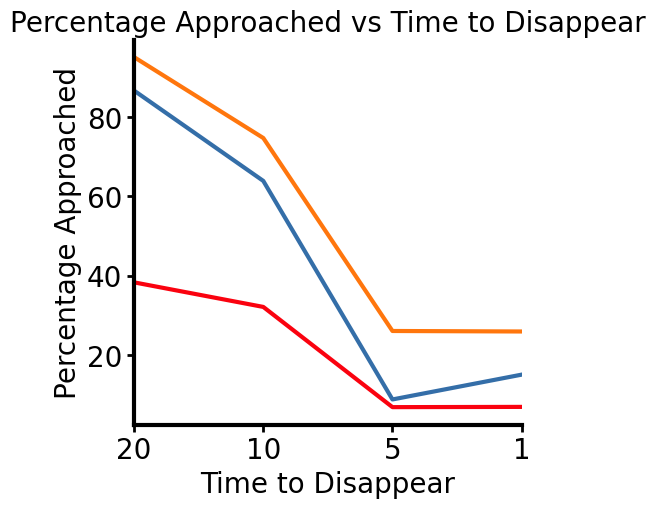

In [8]:
case_mean_results = np.zeros((len(cases), len(times_to_disappear)))
case_mean_results = np.mean(approach_processed[0, :, :, :], axis=1)

for a, case in enumerate(case_mean_results):
    plt.plot(range(4), case, color=case_colors[a])

plt.xlim(3, 0)
plt.xticks(range(4), labels);
plt.title('Percentage Approached vs Time to Disappear')
plt.xlabel('Time to Disappear')
plt.ylabel('Percentage Approached')

## Curriculum Disappearing Success vs Speed

### Results Storage and Hyperparameters

In [4]:
scenario, motion, multisensory, pc, pm, pe, noise, case, motion = constant_hyperparameters()
n_agents = 4
visible_steps = None
times_to_disappear = [1, 5, 10, 20]
cases = ["1", "2", "3"]
pms = np.arange(0, 0.8, 0.25)
case_colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
capture_results = np.zeros((n_agents, len(cases), len(pms), len(times_to_disappear)))
approach_results = np.zeros((n_agents, len(cases), len(pms), len(times_to_disappear)))           
trials = {n: {case: {pm: {time: {} for time in range(len(times_to_disappear))} for pm in range(len(pms))} for case in range(len(cases))} for n in range(n_agents)}

### Agent Training and Testing

In [ ]:
for n in range(n_agents):
    agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=agent_location, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
    evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
    evaluator.train_RL(training_trials = 10000, curriculum=True)

    if n == n_agents - 1:
        # evaluator.training_plots(percentage_captured=True)
        evaluator.training_plots(first_5_last_5=True)

    for case in range(len(cases)):
        for a, pm in tqdm(enumerate(pms)):
            for b in range(len(times_to_disappear)):
                visible_steps = times_to_disappear[b]
                test_trial_data, captured, approached = evaluator.evaluate(n_trials=n_trials, case=cases[case], pm=pm, visible_steps=visible_steps)
                trials[n][case][a][b] = test_trial_data
                capture_results[n, case, a, b] = captured
                approach_results[n, case, a, b] = approached
                # evaluator.agnt.produce_plots(training_lengths=False, first_5_last_5=False, percentage_captured=False, animate=[True, 0], trials=test_trial_data, trial_lengths=[])

### Results Processing and Plotting

In [ ]:
approach_processed = np.zeros((2, len(cases), len(pms), len(times_to_disappear)))

for case in range(len(cases)):
    for pm in range(len(pms)):
        for time in range(len(times_to_disappear)):
            approach_processed[0, case, pm, time] = np.mean(approach_results[:, case, pm, time])
            approach_processed[1, case, pm, time] = np.std(approach_results[:, case, pm, time])

print('Approach Results:')
print(approach_results)
print('Processed Approach Results:')
print(approach_processed)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} RL Approach Success vs Time to Disappear per Speed")

# agents, cases, times, speeds

for pm in range(len(pms)):
    for case in range(len(cases)):
        axs[pm].set_title(f"Speed {pms[pm]}")
        # for n in range(n_agents):
        #     axs[pm].plot(range(4), approach_results[n, case, pm, :], color = case_colors[case], alpha = 0.2)
        
        axs[pm].plot(range(4), approach_processed[0, case, pm, :], color=case_colors[case])
        axs[pm].errorbar(range(4), approach_processed[0, case, pm, :], yerr=approach_processed[1, case, pm, :], color=case_colors[case])
        
labels = [str(time) for time in times_to_disappear]
axs[0].set(xlabel='Time to Disappear', ylabel='Approach Success')
axs[0].set_xticks(range(4), labels);

In [18]:
case_mean_results = np.zeros((len(cases), len(times_to_disappear)))
case_mean_results = np.mean(approach_processed[0, :, :, :], axis=1)

for a, case in enumerate(case_mean_results):
    plt.plot(range(4), case, color=case_colors[a])

plt.xlim(3, 0)
plt.xticks(range(4), labels);
plt.title('Percentage Approached vs Time to Disappear')
plt.xlabel('Time to Disappear')
plt.ylabel('Percentage Approached')